<a href="https://colab.research.google.com/github/FajarRisk1/Project-Capstone-IL/blob/main/Project_Capstone_Bagus_Nur_Fajar_Riski_ACLED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install squarify
!pip install folium

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import squarify
from matplotlib import cm
sns.set_style('ticks')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from wordcloud import WordCloud

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Import Dataset
link = 'https://raw.githubusercontent.com/FajarRisk1/Project-Capstone-IL/main/2015-01-01-2019-01-31-South-Eastern_Asia-Indonesia.csv'
df = pd.read_csv(link, encoding="UTF-8")
df.head(5)

data_id  iso event_id_cnty  event_id_no_cnty       event_date  year  \
0  5590925  360        IDN520               520  31 January 2019  2019   
1  5590925  360        IDN520               520  31 January 2019  2019   
2  6301918  360        IDN526               526  31 January 2019  2019   
3  6301918  360        IDN526               526  31 January 2019  2019   
4  5590924  360        IDN519               519  30 January 2019  2019   

   time_precision                  event_type    sub_event_type  \
0               1                     Battles       Armed clash   
1               1                     Battles       Armed clash   
2               1  Violence against civilians            Attack   
3               1  Violence against civilians            Attack   
4               1                    Protests  Peaceful protest   

                                       actor1  ...     location  latitude  \
0  TPNPB: West Papua National Liberation Army  ...    Mapenduma   -4.3887   
1        Military Forces of Indonesia (2014-)  ...    Mapenduma   -4.3887   
2          Police Forces of Indonesia (2014-)  ...       Wamena   -4.0951   
3                          Civilians (Poland)  ...       Wamena   -4.0951   
4                      Protesters (Indonesia)  ...  Lebak Bulus   -6.3037   

   longitude geo_precision        source source_scale  \
0   138.2340             1  Jakarta Post     National   
1   138.2340             1  Jakarta Post     National   
2   138.9449             1   Pattaya One     Regional   
3   138.9449             1   Pattaya One     Regional   
4   106.7800             1  Jakarta Post     National   

                                               notes fatalities   timestamp  \
0  On January 31, 2019, in Mapenduma village (Ndu...          0  1563366749   
1  On January 31, 2019, in Mapenduma village (Ndu...          0  1563366749   
2  On 31 January 2019, a Polish man in the police...          0  1572403769   
3  On 31 January 2019, a Polish man in the police...          0  1572403769   
4  On January 30, 2019, in Lebak Bulus village of...          0  1563366749   

   iso3  
0   IDN  
1   IDN  
2   IDN  
3   IDN  
4   IDN  

[5 rows x 28 columns]

In [3]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)

    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow  # Perbaikan di sini, menggunakan // untuk pembagian bulat

    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]

        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()

        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')

    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [4]:
dfIndonesia=df[df['country']=='Indonesia']
# Lower all word in event_type
dfIndonesia.event_type = df.event_type.apply(lambda x: x.lower())
event_data = dfIndonesia.groupby('event_type').sum().reset_index()
# Create a new columns that count the numbers of counflicts
d = dict(dfIndonesia.event_type.value_counts())
event_data['conflicts'] = event_data['event_type'].map(d)
# Sort the data by Fatalities
event_data.sort_values(by='fatalities', ascending=False,inplace=True)
#reduce the data to only 8 event type
event_data = event_data.head(8)

<ipython-input-4-d2a939892a82>:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [5]:
#reducing dataset
print(df.columns)
df = df[['actor1', 'country', 'event_date', 'event_type', 'fatalities','latitude', 'location',
       'longitude', 'notes', 'source', 'year']]
#checking if ther's some empty field in percent
#quantity of null elemets division
round((df.isnull().sum()/df.shape[0])*100,2)

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'interaction', 'region', 'country', 'admin1',
       'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'timestamp', 'iso3'],
      dtype='object')


actor1        0.0
country       0.0
event_date    0.0
event_type    0.0
fatalities    0.0
latitude      0.0
location      0.0
longitude     0.0
notes         0.0
source        0.0
year          0.0
dtype: float64

In [6]:
df

actor1    country       event_date  \
0     TPNPB: West Papua National Liberation Army  Indonesia  31 January 2019   
1           Military Forces of Indonesia (2014-)  Indonesia  31 January 2019   
2             Police Forces of Indonesia (2014-)  Indonesia  31 January 2019   
3                             Civilians (Poland)  Indonesia  31 January 2019   
4                         Protesters (Indonesia)  Indonesia  30 January 2019   
...                                          ...        ...              ...   
3116          Police Forces of Indonesia (2014-)  Indonesia  01 January 2015   
3117  TPNPB: West Papua National Liberation Army  Indonesia  01 January 2015   
3118        Military Forces of Indonesia (2014-)  Indonesia  01 January 2015   
3119                         Rioters (Indonesia)  Indonesia  01 January 2015   
3120                   Civilians (International)  Indonesia  01 January 2015   

                      event_type  fatalities  latitude       location  \
0                        Battles           0   -4.3887      Mapenduma   
1                        Battles           0   -4.3887      Mapenduma   
2     Violence against civilians           0   -4.0951         Wamena   
3     Violence against civilians           0   -4.0951         Wamena   
4                       Protests           0   -6.3037    Lebak Bulus   
...                          ...         ...       ...            ...   
3116                    Protests           0   -6.2146        Jakarta   
3117                     Battles           3   -4.4210  Kuala Kencana   
3118                     Battles           3   -4.4210  Kuala Kencana   
3119                       Riots           0    5.8925         Sabang   
3120                       Riots           0    5.8925         Sabang   

      longitude                                              notes  \
0      138.2340  On January 31, 2019, in Mapenduma village (Ndu...   
1      138.2340  On January 31, 2019, in Mapenduma village (Ndu...   
2      138.9449  On 31 January 2019, a Polish man in the police...   
3      138.9449  On 31 January 2019, a Polish man in the police...   
4      106.7800  On January 30, 2019, in Lebak Bulus village of...   
...         ...                                                ...   
3116   106.8450  On 1 January 2015, there was a violent dispers...   
3117   136.8588  On 1 January 2015, two second brigadier office...   
3118   136.8588  On 1 January 2015, two second brigadier office...   
3119    95.3220  On January 1, 2015, an unidentified Muslim gro...   
3120    95.3220  On January 1, 2015, an unidentified Muslim gro...   

                                       source  year  
0                                Jakarta Post  2019  
1                                Jakarta Post  2019  
2                                 Pattaya One  2019  
3                                 Pattaya One  2019  
4                                Jakarta Post  2019  
...                                       ...   ...  
3116                         HumanRightsPapua  2015  
3117  Tempo, Kompas, Papuans Behind Bars, DPA  2015  
3118  Tempo, Kompas, Papuans Behind Bars, DPA  2015  
3119                                   Kompas  2015  
3120                                   Kompas  2015  

[3121 rows x 11 columns]

In [7]:
df.country.value_counts().head()

Indonesia    3121
Name: country, dtype: int64

In [8]:
print("Daftar kolom yang ada pada dataframe : ")
for col in df.columns:
  print(col)

Daftar kolom yang ada pada dataframe : 
actor1
country
event_date
event_type
fatalities
latitude
location
longitude
notes
source
year


## Penjelasan Masing-Masing Kolom

1. actor1 : Aktor bernama yang terlibat dalam kejadian tersebut
2. country : Self Explained
3. event_date : Tanggal kejadian Dicatat sebagai Hari / Bulan / Tahun.
4. event_type : Jenis/Tipe kejadian
5. fatalities : Jumlah atau perkiraan korban jiwa akibat kejadian. Hal ini sering kali berbeda di seluruh laporan
6. latitude : Garis lintang lokasi
7. location : Lokasi tempat kejadian berlangsung.
8. longitude : Garis bujur lokasi
9. notes : Deskripsi singkat tentang kejadian tersebut
10. source : Sumber yang digunakan membuat data ini
11. year : Tahun di mana kejadian terjadi.

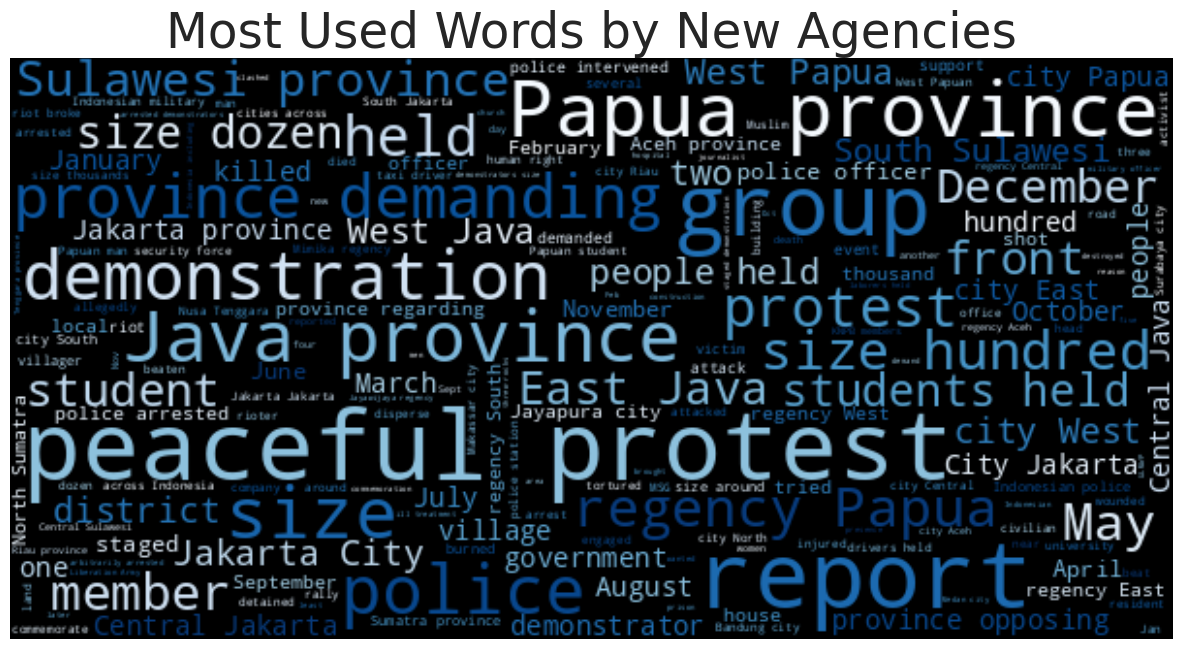

In [9]:
import re
from nltk.corpus import stopwords
clean_1 = re.compile('[/(){}\[\]\|@,;]')
clean_2 = re.compile('[^0-9a-z #+_]')
def clean_text (text):
    text = text.lower()
    text = clean_1.sub(' ',text) # compile and replace those symbole by empty scpace
    text = clean_2.sub('',text)
    text_2 = [word.strip() for word in text.split() if not word in set(stopwords.words('english'))]
    new_text = ''
    for i in text_2:
        new_text +=i+' '
    text = new_text
    return text.strip()
from wordcloud import WordCloud

wc = WordCloud(max_font_size=50, width=600, height=300,colormap='Blues')
wc.generate(' '.join(df['notes'].values))

plt.figure(figsize=(15,8))
plt.imshow(wc,interpolation="bilinear")
plt.title("Most Used Words by New Agencies", fontsize=35)
plt.axis("off")
plt.show()

In [10]:
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['event_type'], **{})
chart

In [11]:
def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['year'], **{})
chart

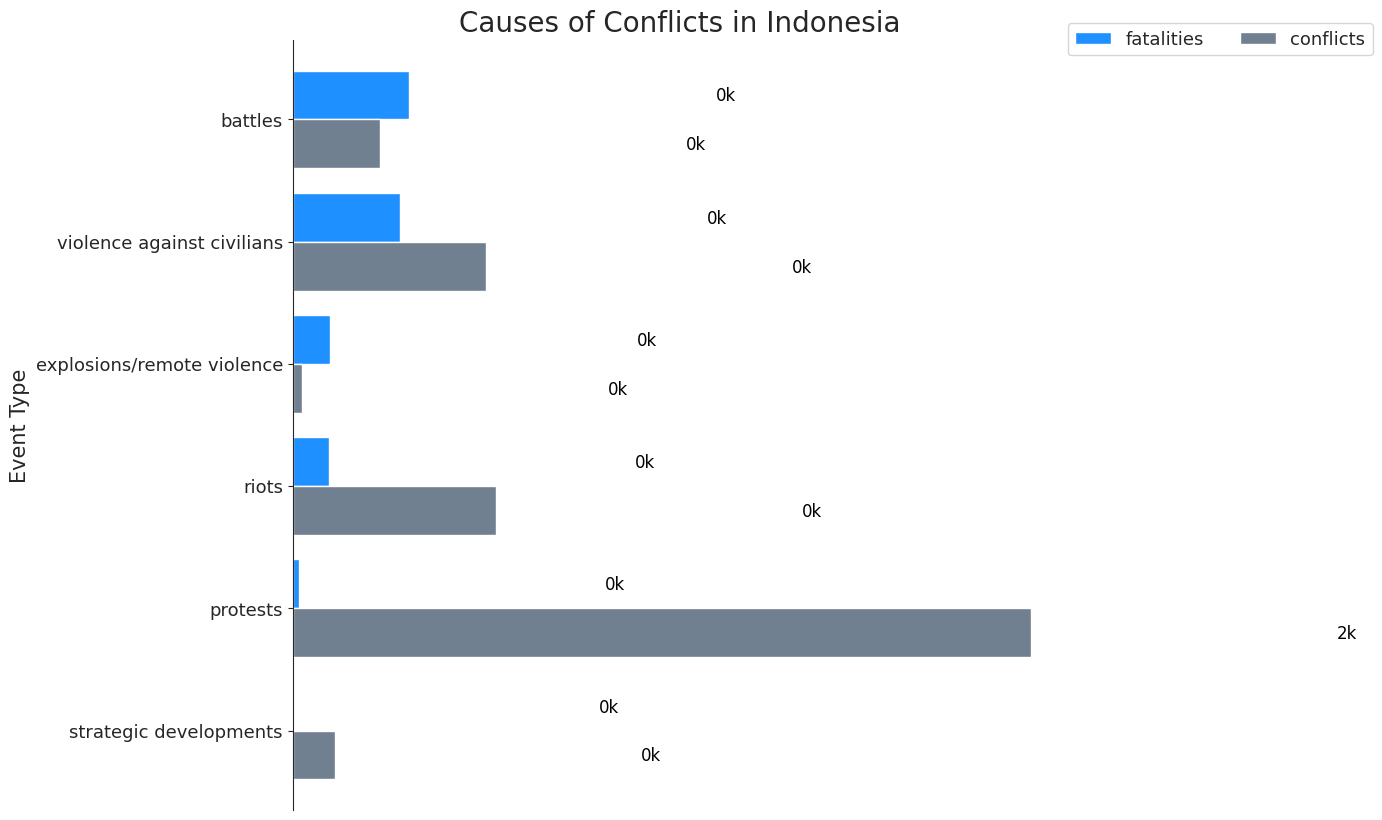

In [12]:
f, ax = plt.subplots(1,1,figsize = (10,10))
ax = event_data[['fatalities', 'conflicts']].plot(kind='barh',ax=ax,width=0.8,
              color=['dodgerblue', 'slategray'], fontsize=13);

ax.set_title("Causes of Conflicts in Indonesia",fontsize=20)
ax.set_ylabel("Event Type", fontsize=15)

ax.set_yticklabels(event_data.event_type.values)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+750, i.get_y()+.25, \
            str(int(round(((i.get_width())/1000))))+'k', fontsize=12, color='black')

# invert for largest on top
ax.invert_yaxis()
sns.despine(bottom=True)
x_axis = ax.axes.get_xaxis().set_visible(False) # turn off the y axis label
plt.legend(loc=(1.0,0.98),fontsize=13,ncol=2)
plt.show()

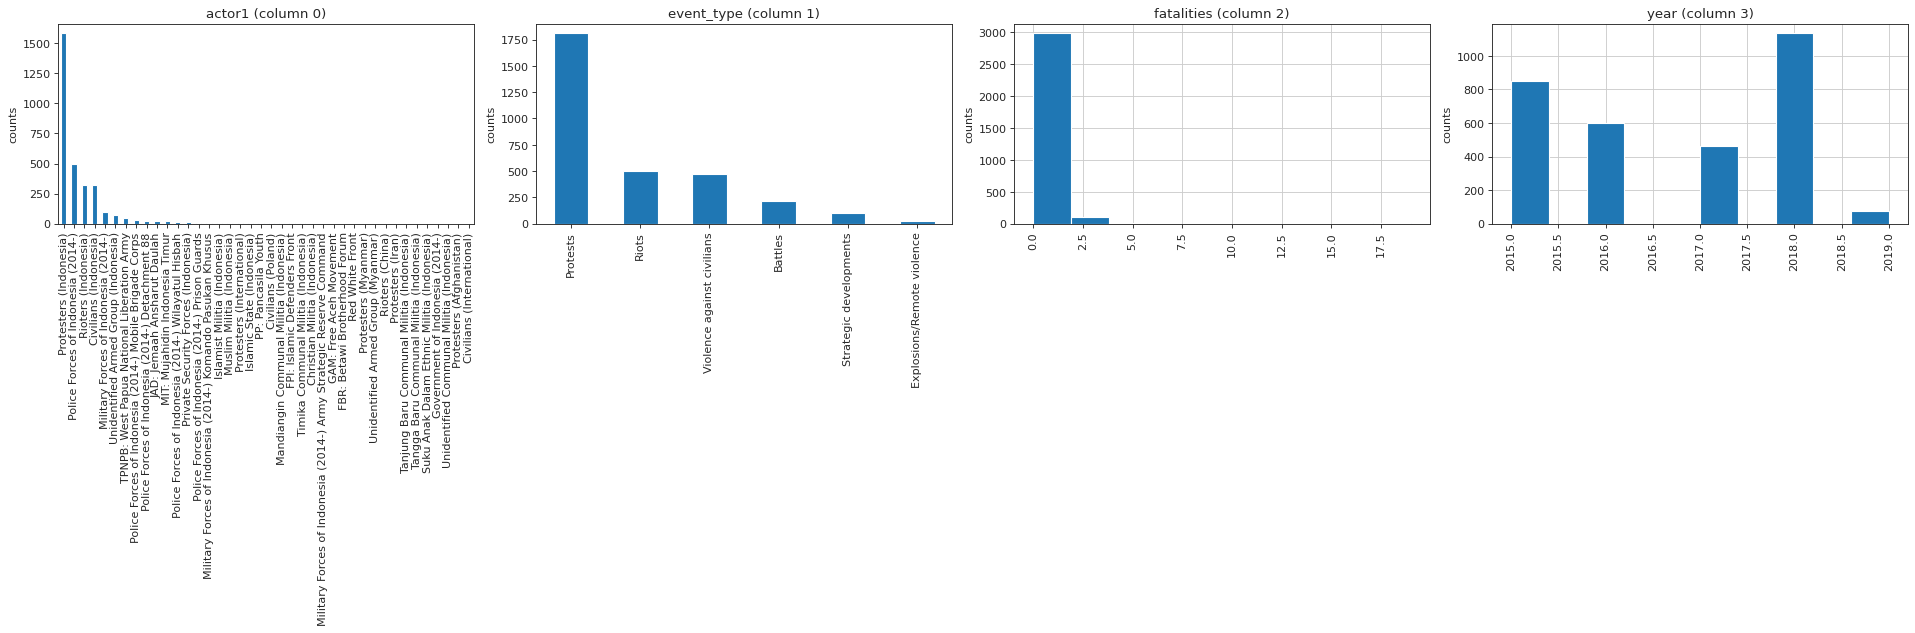

In [13]:
plotPerColumnDistribution(df, 10, 5)

<ipython-input-3-9869bd82be08>:50: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.



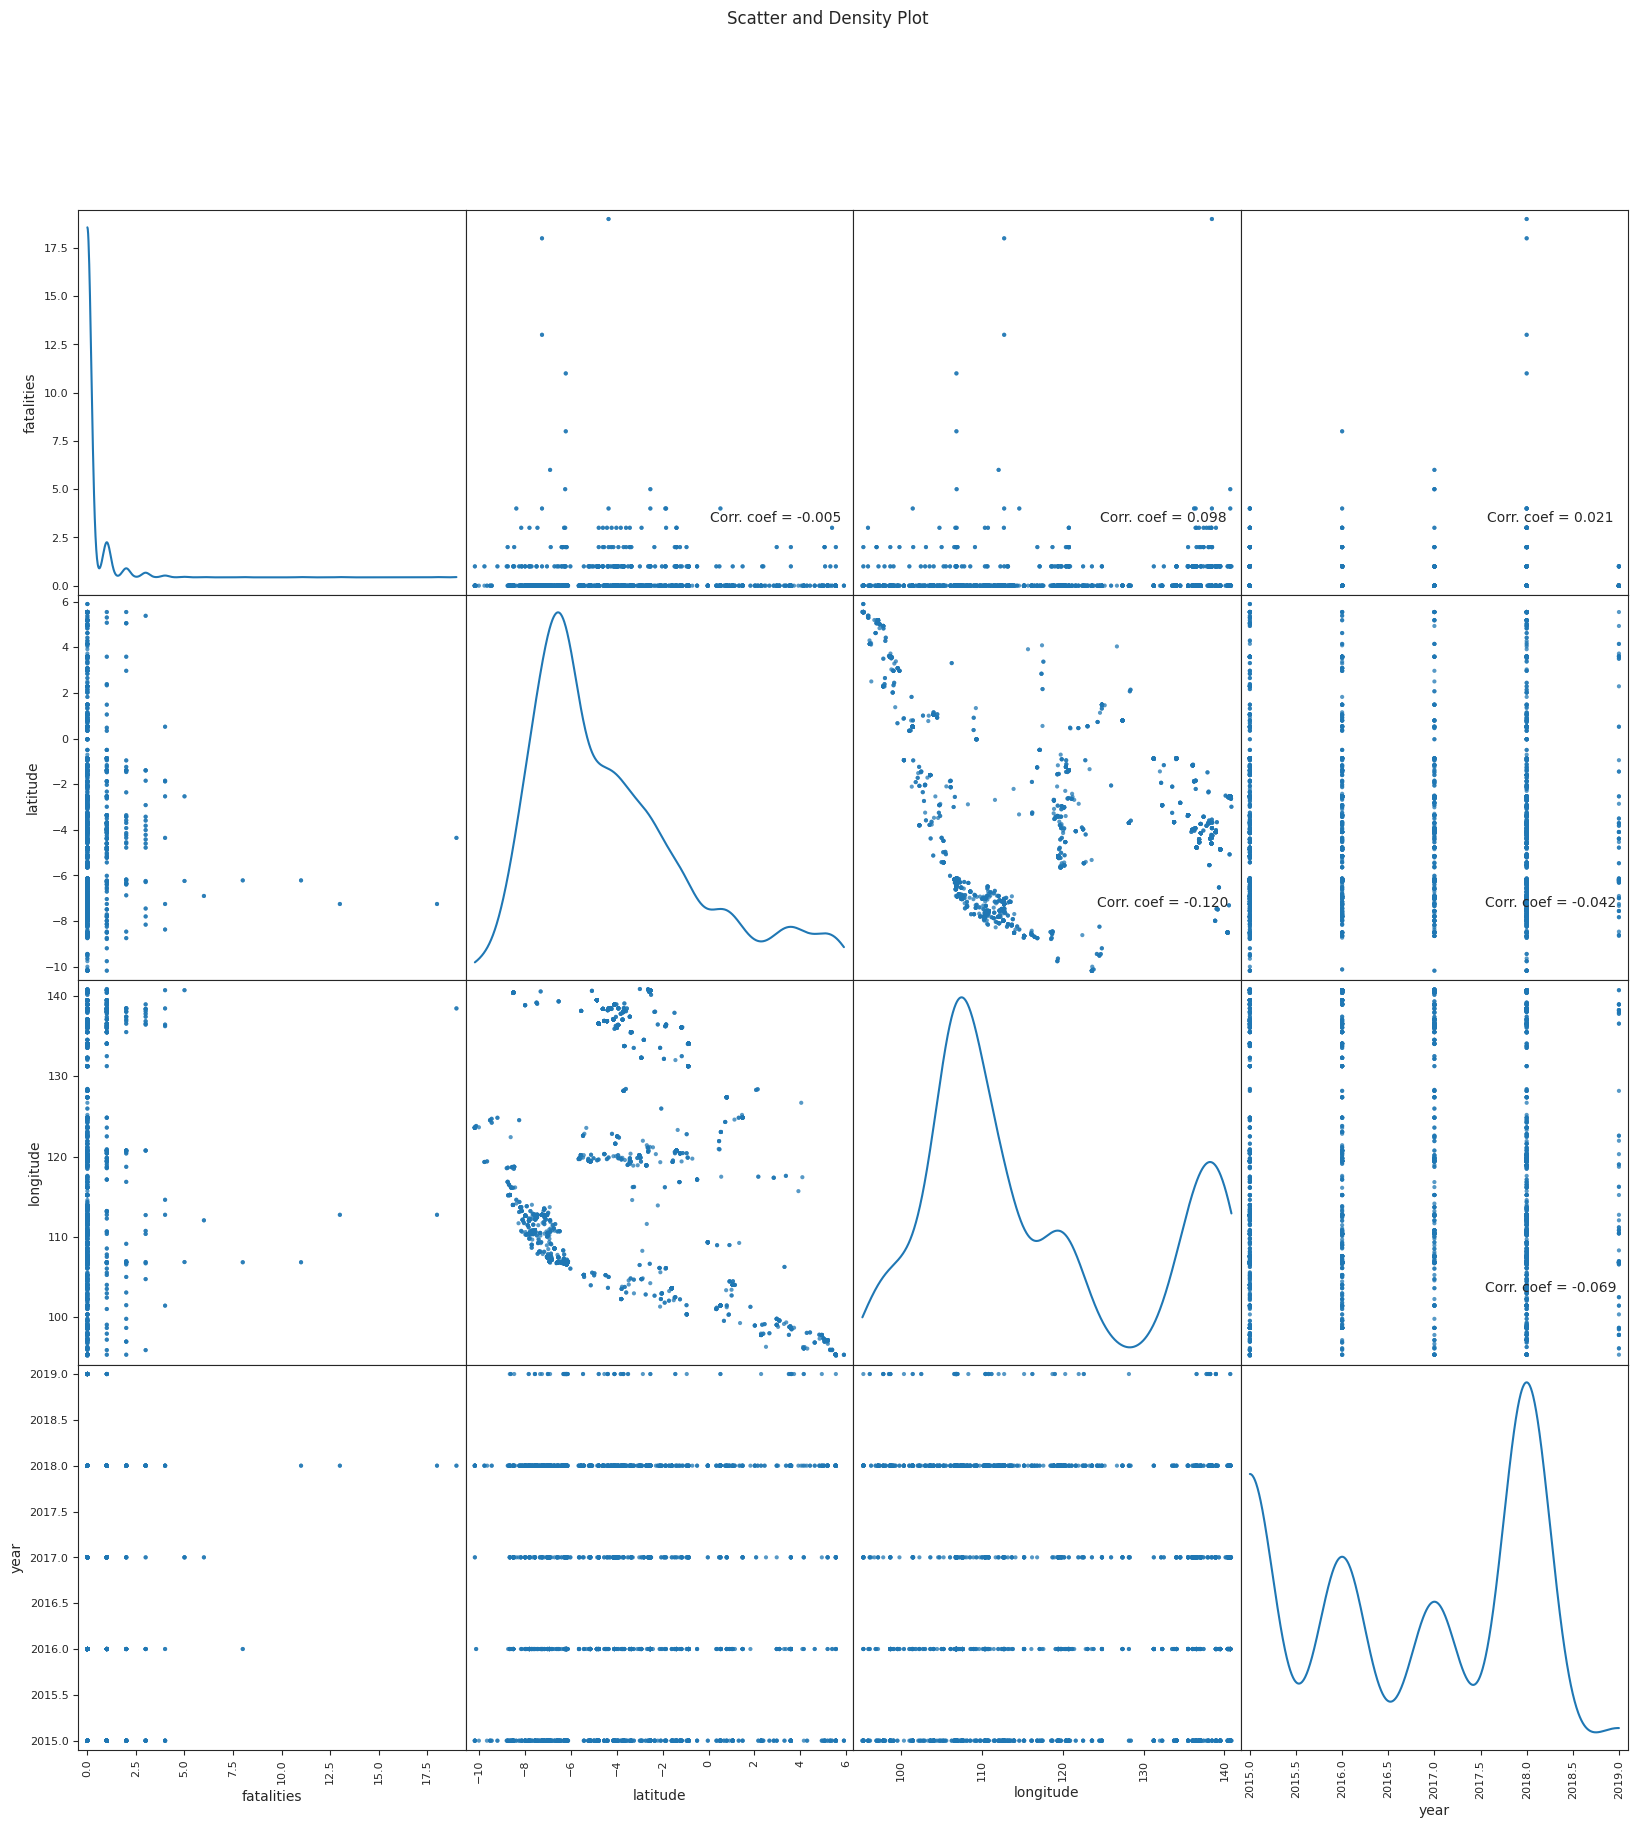

In [14]:
plotScatterMatrix(df, 20, 10)

In [15]:
# Buat Map
map_indonesia = folium.Map(location=[-1.85, 118.04], zoom_start=5)

# Definisikan warna untuk setiap jenis peristiwa
event_colors = {
    'Protests': 'blue',
    'Battles': 'red',
    'Riots': 'green',
    'Violence against civilians': 'orange',
    'Strategic developments': 'purple'
}

# Loop melalui data dan tambahkan marker dengan warna yang sesuai berdasarkan jenis peristiwa
for index, row in df.iterrows():
    event_type = row['event_type']
    if event_type in event_colors:
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            tooltip=row['country'],
            icon=folium.Icon(color=event_colors[event_type])  # Mengatur warna ikon berdasarkan jenis peristiwa
        ).add_to(map_indonesia)

# Menampilkan peta dalam notebook
map_indonesia


In [16]:
# Misalnya, Anda memiliki DataFrame yang sudah bersih bernama df_cleaned
df.to_csv('df_clean.csv', index=False)

In [17]:
df

actor1    country       event_date  \
0     TPNPB: West Papua National Liberation Army  Indonesia  31 January 2019   
1           Military Forces of Indonesia (2014-)  Indonesia  31 January 2019   
2             Police Forces of Indonesia (2014-)  Indonesia  31 January 2019   
3                             Civilians (Poland)  Indonesia  31 January 2019   
4                         Protesters (Indonesia)  Indonesia  30 January 2019   
...                                          ...        ...              ...   
3116          Police Forces of Indonesia (2014-)  Indonesia  01 January 2015   
3117  TPNPB: West Papua National Liberation Army  Indonesia  01 January 2015   
3118        Military Forces of Indonesia (2014-)  Indonesia  01 January 2015   
3119                         Rioters (Indonesia)  Indonesia  01 January 2015   
3120                   Civilians (International)  Indonesia  01 January 2015   

                      event_type  fatalities  latitude       location  \
0                        Battles           0   -4.3887      Mapenduma   
1                        Battles           0   -4.3887      Mapenduma   
2     Violence against civilians           0   -4.0951         Wamena   
3     Violence against civilians           0   -4.0951         Wamena   
4                       Protests           0   -6.3037    Lebak Bulus   
...                          ...         ...       ...            ...   
3116                    Protests           0   -6.2146        Jakarta   
3117                     Battles           3   -4.4210  Kuala Kencana   
3118                     Battles           3   -4.4210  Kuala Kencana   
3119                       Riots           0    5.8925         Sabang   
3120                       Riots           0    5.8925         Sabang   

      longitude                                              notes  \
0      138.2340  On January 31, 2019, in Mapenduma village (Ndu...   
1      138.2340  On January 31, 2019, in Mapenduma village (Ndu...   
2      138.9449  On 31 January 2019, a Polish man in the police...   
3      138.9449  On 31 January 2019, a Polish man in the police...   
4      106.7800  On January 30, 2019, in Lebak Bulus village of...   
...         ...                                                ...   
3116   106.8450  On 1 January 2015, there was a violent dispers...   
3117   136.8588  On 1 January 2015, two second brigadier office...   
3118   136.8588  On 1 January 2015, two second brigadier office...   
3119    95.3220  On January 1, 2015, an unidentified Muslim gro...   
3120    95.3220  On January 1, 2015, an unidentified Muslim gro...   

                                       source  year  
0                                Jakarta Post  2019  
1                                Jakarta Post  2019  
2                                 Pattaya One  2019  
3                                 Pattaya One  2019  
4                                Jakarta Post  2019  
...                                       ...   ...  
3116                         HumanRightsPapua  2015  
3117  Tempo, Kompas, Papuans Behind Bars, DPA  2015  
3118  Tempo, Kompas, Papuans Behind Bars, DPA  2015  
3119                                   Kompas  2015  
3120                                   Kompas  2015  

[3121 rows x 11 columns]

In [18]:
df = df.drop(columns=['actor1'])
df = df.drop(columns=['country'])
df = df.drop(columns=['event_date'])
df = df.drop(columns=['notes'])
df = df.drop(columns=['source'])
df = df.drop(columns=['location'])

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables (replace 'categorical_column' with the actual categorical column)
label_encoder = LabelEncoder()
df['event_type'] = label_encoder.fit_transform(df['event_type'])

# Split the data into features (X) and the target variable (y)
X = df.drop(columns=['event_type'])  # Exclude the target column
y = df['event_type']

# Split the dataset into training and testing sets (adjust the test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, X_train and y_train are your training features and target, and X_test and y_test are your testing features and target.


In [20]:
df

event_type  fatalities  latitude  longitude  year
0              0           0   -4.3887   138.2340  2019
1              0           0   -4.3887   138.2340  2019
2              5           0   -4.0951   138.9449  2019
3              5           0   -4.0951   138.9449  2019
4              2           0   -6.3037   106.7800  2019
...          ...         ...       ...        ...   ...
3116           2           0   -6.2146   106.8450  2015
3117           0           3   -4.4210   136.8588  2015
3118           0           3   -4.4210   136.8588  2015
3119           3           0    5.8925    95.3220  2015
3120           3           0    5.8925    95.3220  2015

[3121 rows x 5 columns]

In [21]:
from sklearn.model_selection import KFold

# Inisialisasi KFold Cross Validation dengan 5 lipatan (folds)
n_splits = 5  # Anda dapat mengganti jumlah folds sesuai kebutuhan
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Anda dapat menggunakannya dalam loop untuk melatih dan menguji model pada setiap fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Di sini Anda dapat melatih dan menguji model Anda pada setiap fold
    # Gunakan X_train dan y_train untuk melatih model
    # Gunakan X_test dan y_test untuk menguji model

    # Contoh:
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)

    # Setelah itu, Anda dapat mengukur metrik evaluasi model, seperti akurasi, presisi, dll.


In [22]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# Inisialisasi berbagai model yang akan digunakan dalam ensemble
decision_tree_model = DecisionTreeClassifier(random_state=42)
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
svm_model = SVC(probability=True, random_state=42)

# Membuat ensemble classifier
ensemble_classifier = VotingClassifier(estimators=[
    ('Decision Tree', decision_tree_model),
    ('Random Forest', random_forest_model),
    ('Gradient Boosting', gradient_boosting_model),
    ('SVM', svm_model)
], voting='soft')  # Anda dapat memilih 'hard' atau 'soft' voting

# Anda dapat melatih ensemble classifier ini pada dataset Anda seperti ini:
ensemble_classifier.fit(X_train, y_train)

# Sekarang Anda memiliki sebuah ensemble classifier yang terlatih dan dapat digunakan untuk membuat prediksi.


VotingClassifier(estimators=[('Decision Tree',
                              DecisionTreeClassifier(random_state=42)),
                             ('Random Forest',
                              RandomForestClassifier(random_state=42)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         random_state=42)),
                             ('SVM', SVC(probability=True, random_state=42))],
                 voting='soft')

In [23]:
from sklearn.model_selection import cross_val_score

# Lakukan cross-validation untuk mengukur performa ensemble classifier
cv_scores = cross_val_score(ensemble_classifier, X_train, y_train, cv=5, scoring='accuracy')

# Tampilkan skor akurasi untuk setiap fold
for i, score in enumerate(cv_scores, start=1):
    accuracy_percent = score * 100  # Konversi ke persen
    print(f"Fold {i} - Accuracy: {accuracy_percent:.2f}%")

# Hitung rata-rata skor akurasi dari seluruh fold
mean_accuracy = np.mean(cv_scores)
mean_accuracy_percent = mean_accuracy * 100  # Konversi ke persen
print(f"Rata-rata Akurasi: {mean_accuracy_percent:.2f}%")


Fold 1 - Accuracy: 61.00%
Fold 2 - Accuracy: 61.60%
Fold 3 - Accuracy: 46.89%
Fold 4 - Accuracy: 54.31%
Fold 5 - Accuracy: 45.49%
Rata-rata Akurasi: 53.86%


In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Melatih model pada seluruh data pelatihan
ensemble_classifier.fit(X_train, y_train)

# Sekarang, model Anda telah dilatih pada seluruh data pelatihan
# Anda dapat menggunakannya untuk membuat prediksi pada data baru

# Misalnya, jika Anda memiliki data baru dalam variabel X_new
# X_new adalah array atau dataframe dengan fitur yang sesuai
y_pred = ensemble_classifier.predict(X_test)

# Ukur akurasi prediksi
accuracy = accuracy_score(y_test, y_pred)

print("Hasil Prediksi:")
print(y_pred)
print("\nAkurasi Prediksi: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Matriks Keakuratan
confusion = confusion_matrix(y_test, y_pred)
print("\nMatriks Keakuratan:\n")
print(confusion)


Hasil Prediksi:
[0 2 3 2 4 2 3 3 3 0 2 4 0 2 2 2 2 2 2 5 5 2 2 5 3 2 5 3 2 2 3 5 2 2 2 0 2
 5 5 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 5 2 2 2 2 0 2 2 2 2 2 2 3 2 4 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 5 2 5 2 2 2 2 2 2 3 2 0 2 2 2 2 5 2 2 2 2 2
 2 2 2 2 2 3 3 2 3 0 5 5 2 2 2 2 2 2 5 3 0 4 3 5 0 5 2 2 2 2 2 2 2 5 3 2 0
 2 0 0 0 0 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 2 2 2 2 2 2 5 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 5 2 5 2 2
 2 2 2 3 2 5 2 2 2 5 2 2 2 3 2 2 2 2 2 5 5 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 5
 5 5 2 5 2 0 5 2 2 0 5 2 5 2 2 4 5 5 2 3 3 2 2 2 5 2 2 2 3 5 2 5 3 5 5 5 5
 2 2 2 1 1 1 5 2 2 2 2 2 0 5 2 2 2 5 5 2 5 2 2 2 2 2 2 2 5 2 2 2 2 5 2 2 0
 2 3 2 2 5 3 3 2 5 2 2 2 2 2 5 2 2 2 2 2 3 2 3 3 2 2 2 2 2 3 2 2 2 5 0 2 5
 2 2 5 3 5 2 2 2 2 3 2 3 2 2 3 3 2 0 2 2 5 2 2 2 2 2 5 2 2 2 2 2 2 2 2 5 2
 5 5 2 5 3 0 2 2 2 2 2 5 5 2 2 3 5 2 5 0 2 5 2 2 2 2 2 2 2 2 2 5 0 2 2 4 2
 2 2 2 4 2 2 2 2 2 2 3 2 2 2 2 0 2 0 2 3 2 4 2 2 5 2 2 2 2 2 2 2 2 2 2 2 3
 0 3 2 2 